## Image Similarity Search

**1. Objective:**

- Develop an alternative to Google Lens by implementing image similarity search using multiple approaches.

**2. Methods:**

- Propose 4-5 distinct methods for performing similarity search. Potential approaches could include:
- Feature extraction using pre-trained convolutional neural networks (CNNs) like ResNet, VGG, or EfficientNet, followed by nearest neighbor search (e.g., k-NN or cosine similarity).
- Deep metric learning approaches such as Siamese Networks or Triplet Loss-based models
- Visual embeddings generated via Vision Transformers (ViTs) or CLIP.
- Hashing-based methods such as Locality Sensitive Hashing (LSH) or deep learning-based hashing
- Autoencoder-based image reconstruction to map images into a latent space for similarity comparison.

**3. Fine-tuning:**

- Fine-tune the image dataset for each of the proposed approaches
- Compare the performance of each approach by evaluating metrics such as precision, recall, and retrieval accuracy for the similarity search task.
- Consider computational efficiency and scalability for real-time usage scenarios.

**4. Deliverables:**

- A detailed report comparing the results and performance of all methods.
- Insights into which method works best for specific use cases (e.g., speed vs accuracy, handling various image types, etc.).

## Feature extraction using pre-trained convolutional neural networks (CNNs) like ResNet, VGG, or EfficientNet, followed by nearest neighbor search (e.g., k-NN or cosine similarity)



In [1]:
!pip install tensorflow

In [2]:
import requests
import os
import numpy as np
from numpy.linalg import norm
import joblib as pickle
from tqdm import tqdm
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
import gc
from tensorflow.keras.applications.resnet50 import ResNet50
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import random
from pathlib import Path

import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model

In [14]:
from google.colab import drive
drive.mount('/content/drive')

import requests
import os
import zipfile
import tarfile

def download_and_extract(url, extract_path):
    """Downloads and extracts a zip or tar file.

    Args:
        url: The URL of the file to download.
        extract_path: The directory to extract the file to.
    """
    try:
        local_filename = url.split('/')[-1]
        local_filename = local_filename.split('?')[0] # Handle query parameters in URL

        if not os.path.exists(extract_path):
            os.makedirs(extract_path)

        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total_size = int(r.headers.get('content-length', 0))
            block_size = 1024  # 1KB
            with open(os.path.join(extract_path, local_filename), 'wb') as f:
                for data in tqdm(r.iter_content(block_size), total=math.ceil(total_size//block_size), unit='KB', unit_scale=True):
                    f.write(data)

        if local_filename.endswith('.zip'):
            with zipfile.ZipFile(os.path.join(extract_path, local_filename), 'r') as zip_ref:
                zip_ref.extractall(extract_path)
        elif local_filename.endswith(('.tar', '.tar.gz', '.tgz')):
            with tarfile.open(os.path.join(extract_path, local_filename), 'r') as tar_ref:
                tar_ref.extractall(extract_path)
        else:
            print(f"Unsupported file format: {local_filename}")

        os.remove(os.path.join(extract_path, local_filename)) # Remove the downloaded file
    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")
    except zipfile.BadZipFile as e:
        print(f"Error extracting zip file: {e}")
    except tarfile.TarError as e:
        print(f"Error extracting tar file: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


# Example usage
url = 'https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1'
extract_path = '/content/drive/MyDrive/Caltech101'  # Replace with your desired extraction path

download_and_extract(url, extract_path)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


134kKB [00:03, 36.6kKB/s]                          


In [ ]:
# with tarfile.open("/content/drive/MyDrive/Caltech101/caltech-101/101_ObjectCategories.tar.gz", 'r') as tar_ref:
#                 tar_ref.extractall(extract_path)

In [ ]:
tar_ref.close()
!rm -rf  '/content/drive/MyDrive/Caltech101/101_ObjectCategories/BACKGROUND_Google' #Linux

In [6]:
img_size =224

model = ResNet50(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')
model2 = VGG16(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

model3 = EfficientNetV2B0(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

In [7]:
import pickle
import numpy as np

# Example: Save the ResNet model
with open('resnet.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('effnet.pkl', 'wb') as f:
    pickle.dump(model3, f)

NameError: name 'datagen' is not defined

In [11]:
from PIL import Image

def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify the file is an image
        return True
    except (IOError, SyntaxError):
        return


In [ ]:
!pip install tqdm


In [12]:
import os
import math
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2  import preprocess_input as envpre
from tensorflow.keras.applications.vgg16 import preprocess_input as vggpre
from tensorflow.keras.applications.resnet50 import preprocess_input as respre

from tqdm import tqdm  # Import tqdm for progress bar


# Function to validate image files and catch UnidentifiedImageError
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify the file is a valid image
        return True
    except (IOError, SyntaxError, UnidentifiedImageError):
        return False

# Parameters
batch_size = 64
root_dir = '/content/drive/MyDrive/Caltech101/101_ObjectCategories'
img_size = 224  # Update as per your model requirements

# Create ImageDataGenerator
img_gen = ImageDataGenerator(preprocessing_function=vggpre)

# Load all files and validate them
datagen = img_gen.flow_from_directory(
    root_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

# Validate and filter files with a progress bar
# print("Validating images...")
# valid_files = []
# for file in tqdm(datagen.filenames, desc="Validation Progress"):
#     if is_valid_image(os.path.join(root_dir, file)):
#         valid_files.append(file)

# print(f"Number of valid images: {len(valid_files)}")

# # Filter the valid filenames in the data generator
# datagen.filenames = valid_files

# Recompute the number of images and epochs
num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

# Debugging the valid filenames
print("Valid filenames:", datagen.filenames[:10])  # Print the first 10 valid files for verification

Found 8677 images belonging to 101 classes.
Valid filenames: ['Faces/image_0001.jpg', 'Faces/image_0002.jpg', 'Faces/image_0003.jpg', 'Faces/image_0004.jpg', 'Faces/image_0005.jpg', 'Faces/image_0006.jpg', 'Faces/image_0007.jpg', 'Faces/image_0008.jpg', 'Faces/image_0009.jpg', 'Faces/image_0010.jpg']


In [13]:
with open('image_paths.pkl', 'wb') as f:
    pickle.dump(datagen.filenames, f)

In [ ]:
# Ensure GPU is available
if tf.config.list_physical_devices('GPU'):
    print("Running on GPU!")
else:
    print("GPU not available, running on CPU.")

# Predict features using the model
try:
    feature_list = model2.predict(datagen, num_epochs)
    print("Num images   = ", num_images)
    print("Shape of feature_list = ", feature_list.shape)
except Exception as e:
    print(f"Error during prediction: {e}")

GPU not available, running on CPU.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


136/136 ━━━━━━━━━━━━━━━━━━━━ 5699s 42s/step
Num images   =  8677
Shape of feature_list =  (8677, 512)


In [ ]:
import numpy as np

# Save the feature_list as a .npy file
file_name = "vgg.npy"
np.save(file_name, feature_list)

# Download the file to your local system
from google.colab import files
files.download(file_name)

print(f"Feature list saved and ready for download as {file_name}.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Feature list saved and ready for download as vgg.npy.


In [ ]:
# Predict features using the model
try:
    feature_list = model2.predict(datagen, num_epochs)
    print("Num images   = ", num_images)
    print("Shape of feature_list = ", feature_list.shape)
except Exception as e:
    print(f"Error during prediction: {e}")

In [ ]:
filenames = [root_dir + '/' + s for s in datagen.filenames]

In [ ]:
# prompt: /content/drive/MyDrive/Caltech101/image_cos2 access this folder and save the foldernames/classes in a csv file for seperating into multiple collections of parent classes to curate specialised datasets

import pandas as pd
import os

# Assuming 'root_dir' is defined as in your previous code
root_dir = '/content/drive/MyDrive/Caltech101/101_ObjectCategories'

# Get a list of all subdirectories (classes) in the root directory
classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

# Create a DataFrame from the list of classes
df = pd.DataFrame({'class_name': classes})

# Save the DataFrame to a CSV file
csv_filepath = '/content/drive/MyDrive/Caltech101/classes.csv'  # Choose your desired file path
df.to_csv(csv_filepath, index=False)

print(f"Classes saved to {csv_filepath}")

In [ ]:
import pandas as pd
import os
import shutil
from transformers import pipeline

# Load the classes.csv file
df_classes = pd.read_csv('/content/drive/MyDrive/Caltech101/classes.csv')

# Define parent categories
parent_categories = ["Animals", "Appliances", "Clothes", "Vehicles", "Nature", "Furniture", "Electronics", "Miscellaneous"]

# Load a text classification model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Function to classify class names into parent categories
def classify_class_name(class_name):
    result = classifier(class_name, parent_categories)
    return result['labels'][0]  # Return the best matching parent category

# Source directory for original class folders
source_root = '/content/drive/MyDrive/Caltech101/101_ObjectCategories'

# Destination root for organizing folders
destination_root = '/content/drive/MyDrive/Caltech101/Organized_Classes'

# Create the destination root folder if it doesn't exist
if not os.path.exists(destination_root):
    os.makedirs(destination_root)

# Loop through each class name in the CSV
for class_name in df_classes['class_name']:
    # Get the predicted parent category
    parent_category = classify_class_name(class_name)

    # Create a folder for the parent category if it doesn't exist
    parent_folder = os.path.join(destination_root, parent_category)
    if not os.path.exists(parent_folder):
        os.makedirs(parent_folder)

    # Copy the class folder from the source to the parent folder
    source_class_folder = os.path.join(source_root, class_name)
    destination_class_folder = os.path.join(parent_folder, class_name)
    if os.path.exists(source_class_folder):
        shutil.copytree(source_class_folder, destination_class_folder, dirs_exist_ok=True)
        print(f"Copied '{class_name}' to '{parent_category}'")
    else:
        print(f"Source folder for '{class_name}' does not exist.")

print("Classification and folder organization completed!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Copied 'pizza' to 'Miscellaneous'
Copied 'platypus' to 'Animals'
Copied 'pyramid' to 'Electronics'
Copied 'revolver' to 'Vehicles'
Copied 'rooster' to 'Animals'
Copied 'rhino' to 'Animals'
Copied 'saxophone' to 'Electronics'
Copied 'schooner' to 'Vehicles'
Copied 'scissors' to 'Miscellaneous'
Copied 'scorpion' to 'Animals'
Copied 'sea_horse' to 'Animals'
Copied 'snoopy' to 'Animals'
Copied 'soccer_ball' to 'Miscellaneous'
Copied 'stapler' to 'Vehicles'
Copied 'starfish' to 'Animals'
Copied 'stegosaurus' to 'Animals'
Copied 'strawberry' to 'Nature'
Copied 'stop_sign' to 'Vehicles'
Copied 'sunflower' to 'Nature'
Copied 'tick' to 'Furniture'
Copied 'trilobite' to 'Nature'
Copied 'umbrella' to 'Miscellaneous'
Copied 'watch' to 'Nature'
Copied 'water_lilly' to 'Nature'
Copied 'wheelchair' to 'Vehicles'
Copied 'wild_cat' to 'Animals'
Copied 'wrench' to 'Electronics'
Copied 'windsor_chair' to 'Furniture'
Copied 'yin_yang' to 'Nature'
Copied 'cougar_body' to 'Animals'
Copied 'Faces' to 'Animal

In [ ]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='minkowski')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='ball_tree')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cat.jpg to cat.jpg


In [ ]:
img_path = 'cat.jpg'
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = respre(expanded_img_array)
test_img_features = model.predict(preprocessed_img, batch_size=1)
print(test_img_features.shape)
_, indices = neighbors.kneighbors(test_img_features)
print(indices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
(1, 2048)


NameError: name 'neighbors' is not defined

(1, 5)


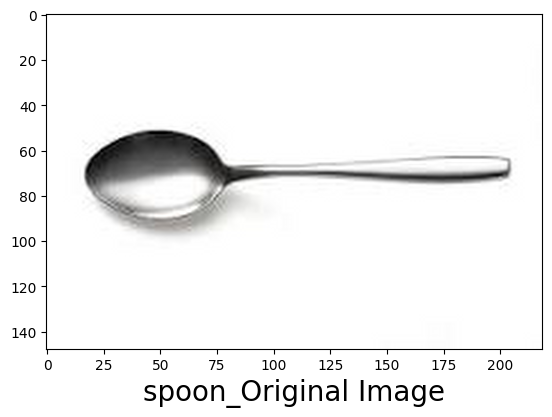

********* Predictions ***********


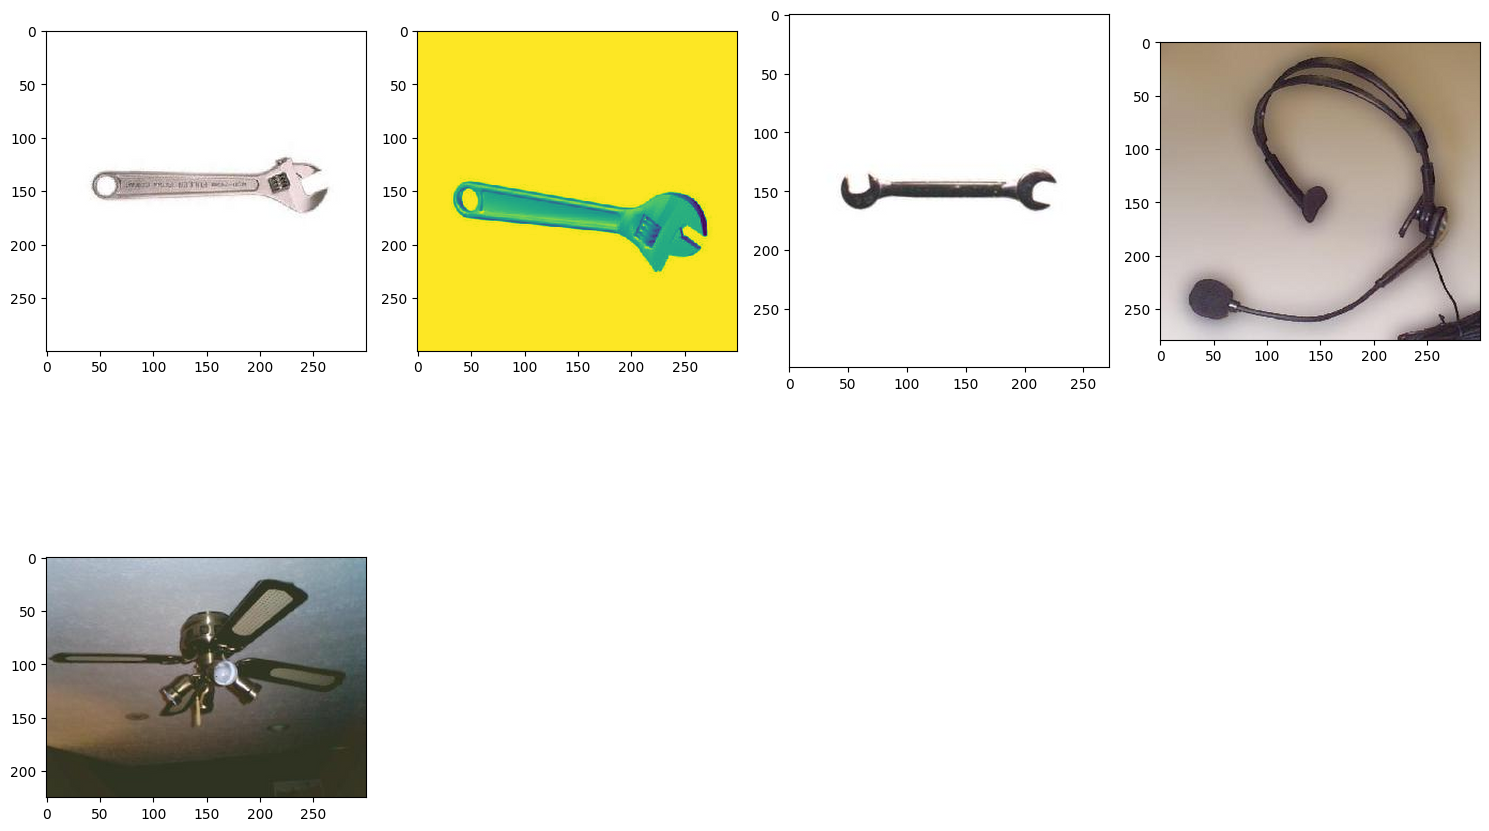

In [ ]:
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1
    for index in indices:
        print(index)
        if plotnumber<=len(indices) :
            ax = plt.subplot(2,4,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')
            plotnumber+=1
    plt.tight_layout()

print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving eff.npy to eff.npy


In [15]:

# Load the .npy file into a NumPy array
npy_file_path = "/content/drive/MyDrive/Caltech101/res.npy"

try:
    feature_list = np.load(npy_file_path)
    print("Loaded feature list successfully!")
    print("Shape of the feature list:", feature_list.shape)
except Exception as e:
    print(f"Error loading .npy file: {e}")

Loaded feature list successfully!
Shape of the feature list: (8677, 2048)


In [ ]:
pca = PCA(n_components=100)
pca.fit(feature_list)
compressed_features = pca.transform(feature_list)

In [16]:
neighbors_pca_features = NearestNeighbors(n_neighbors=5,
                             algorithm='kd_tree', metric='l2')
neighbors_pca_features.fit(feature_list)

NearestNeighbors(algorithm='kd_tree', metric='l2')

In [17]:
with open('nearest_neighbors.pkl', 'wb') as f:
    pickle.dump(neighbors_pca_features, f)

In [ ]:
        ground_truth_label = extract_label(query_image)

        # Preprocess the query image
        img = image.load_img(query_image, target_size=(img_size, img_size))
        img_array = image.img_to_array(img)
        expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = respre(expanded_img_array)

test_img_features = model.predict(preprocessed_img, batch_size=1)
retrieval_time = time.time() - start_time
_, indices = neighbors.kneighbors(test_img_features)

print()

In [23]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import precision_score, recall_score, ndcg_score
from tqdm import tqdm

# Helper function to extract the label from the path
def extract_label(img_path):
    return os.path.basename(os.path.dirname(img_path))

# Pick 3-4 random images from each subfolder
def sample_images(folder_path, num_samples=3):
    sampled_images = []
    for root, _, files in os.walk(folder_path):
        if files:
            sampled = random.sample(files, min(num_samples, len(files)))
            sampled_images.extend([os.path.join(root, img) for img in sampled])
    return sampled_images

# Similarity search and evaluation
def evaluate_similarity_search(query_images, model, neighbors, filenames):
    precision_scores, recall_scores, ndcg_scores, retrieval_times = [], [], [], []

    print("\n=== Starting Similarity Search Evaluation ===")
    for query_image in tqdm(query_images, desc="Processing Query Images"):
        # Extract the ground-truth label
        ground_truth_label = extract_label(query_image)

        # Preprocess the query image
        img = image.load_img(query_image, target_size=(img_size, img_size))
        img_array = image.img_to_array(img)
        expanded_img_array = np.expand_dims(img_array, axis=0)
        preprocessed_img = envpre(expanded_img_array)

        # Extract features and perform similarity search
        start_time = time.time()
        test_img_features = model.predict(preprocessed_img, batch_size=1)
        retrieval_time = time.time() - start_time
        _, indices = neighbors.kneighbors(test_img_features)

        # Collect predicted labels
        predicted_labels = [extract_label(filenames[idx]) for idx in indices[0]]

        # Calculate precision, recall, and nDCG
        true_labels = [1 if label == ground_truth_label else 0 for label in predicted_labels]
        precision = precision_score(true_labels, [1] * len(true_labels), zero_division=1)
        recall = recall_score(true_labels, [1] * len(true_labels), zero_division=1)
        ndcg = ndcg_score([true_labels], [[1] * len(true_labels)])

        # Store metrics
        precision_scores.append(precision)
        recall_scores.append(recall)
        ndcg_scores.append(ndcg)
        retrieval_times.append(retrieval_time)

        # Display query and similar images
        # plt.imshow(mpimg.imread(query_image))
        # plt.title(f"Query: {ground_truth_label}")
        # plt.axis('off')
        # plt.show()

        # print(f"Predicted labels: {predicted_labels}")
        # print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, nDCG: {ndcg:.2f}, Retrieval Time: {retrieval_time:.2f}s")

    # Report average metrics
    print("\n=== Average Metrics ===")
    print(f"Precision: {np.mean(precision_scores):.2f}")
    print(f"Recall: {np.mean(recall_scores):.2f}")
    print(f"nDCG: {np.mean(ndcg_scores):.2f}")
    print(f"Retrieval Time: {np.mean(retrieval_times):.2f}s")

# Paths and configurations
folder_path = '/content/drive/MyDrive/Caltech101/Organized_Classes'
query_images = sample_images(folder_path)
filenames = datagen.filenames  # List of all file paths used for similarity search

# Evaluate the similarity search model
evaluate_similarity_search(query_images, model3, neighbors_pca_features, filenames)



=== Starting Similarity Search Evaluation ===


Processing Query Images:   0%|          | 0/303 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Processing Query Images:   0%|          | 1/303 [00:00<01:13,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Processing Query Images:   1%|          | 2/303 [00:00<01:38,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Processing Query Images:   1%|          | 3/303 [00:00<01:25,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Query Images:   1%|▏         | 4/303 [00:01<01:50,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Query Images:   2%|▏         | 5/303 [00:01<02:02,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Query Images:   2%|▏         | 6/303 [00:02<02:08,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Query Images:   2%|▏         | 7/303 [00:02<02:12,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:   3%|▎         | 8/303 [00:03<02:04,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:   3%|▎         | 9/303 [00:03<01:59,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Query Images:   3%|▎         | 10/303 [00:03<01:56,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:   4%|▎         | 11/303 [00:04<01:51,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Query Images:   4%|▍         | 12/303 [00:04<01:47,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:   4%|▍         | 13/303 [00:04<01:46,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:   5%|▍         | 14/303 [00:05<01:52,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Query Images:   5%|▌         | 16/303 [00:05<01:30,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Query Images:   6%|▌         | 17/303 [00:06<01:30,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:   6%|▋         | 19/303 [00:06<01:20,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:   7%|▋         | 21/303 [00:07<01:11,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:   7%|▋         | 22/303 [00:07<01:24,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:   8%|▊         | 23/303 [00:07<01:29,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:   8%|▊         | 24/303 [00:08<01:34,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Query Images:   8%|▊         | 25/303 [00:08<01:40,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Query Images:   9%|▊         | 26/303 [00:09<01:40,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:   9%|▉         | 27/303 [00:09<01:38,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:   9%|▉         | 28/303 [00:09<01:35,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  10%|▉         | 29/303 [00:10<01:49,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  10%|▉         | 30/303 [00:10<01:43,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  10%|█         | 31/303 [00:11<01:51,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  11%|█         | 32/303 [00:11<01:52,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  11%|█         | 33/303 [00:11<01:48,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  11%|█         | 34/303 [00:12<01:44,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Query Images:  12%|█▏        | 35/303 [00:12<01:40,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Query Images:  12%|█▏        | 37/303 [00:13<01:31,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Query Images:  13%|█▎        | 38/303 [00:13<01:41,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Query Images:  13%|█▎        | 39/303 [00:14<01:39,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Query Images:  13%|█▎        | 40/303 [00:14<01:36,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Query Images:  14%|█▎        | 41/303 [00:14<01:38,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Query Images:  14%|█▍        | 42/303 [00:15<01:34,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Query Images:  14%|█▍        | 43/303 [00:15<01:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Query Images:  15%|█▍        | 44/303 [00:15<01:28,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Query Images:  15%|█▍        | 45/303 [00:16<01:27,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  15%|█▌        | 46/303 [00:16<01:27,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  16%|█▌        | 47/303 [00:16<01:28,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  16%|█▌        | 48/303 [00:17<01:31,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Query Images:  16%|█▌        | 49/303 [00:17<01:30,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  17%|█▋        | 50/303 [00:17<01:30,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  17%|█▋        | 51/303 [00:18<01:26,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Query Images:  17%|█▋        | 52/303 [00:18<01:24,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Query Images:  17%|█▋        | 53/303 [00:19<01:36,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  18%|█▊        | 54/303 [00:19<01:34,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Query Images:  18%|█▊        | 55/303 [00:19<01:35,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  18%|█▊        | 56/303 [00:20<01:32,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  19%|█▉        | 57/303 [00:20<01:28,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  19%|█▉        | 58/303 [00:20<01:28,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  19%|█▉        | 59/303 [00:21<01:30,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Query Images:  20%|█▉        | 60/303 [00:21<01:27,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Query Images:  20%|██        | 61/303 [00:21<01:26,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  20%|██        | 62/303 [00:22<01:22,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Query Images:  21%|██        | 63/303 [00:22<01:23,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Query Images:  21%|██        | 64/303 [00:22<01:23,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  21%|██▏       | 65/303 [00:23<01:21,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  22%|██▏       | 66/303 [00:23<01:23,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  22%|██▏       | 67/303 [00:24<01:22,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  22%|██▏       | 68/303 [00:24<01:19,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  23%|██▎       | 69/303 [00:24<01:22,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Query Images:  23%|██▎       | 71/303 [00:25<01:07,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Query Images:  24%|██▍       | 72/303 [00:25<01:11,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Query Images:  24%|██▍       | 73/303 [00:25<01:13,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Query Images:  24%|██▍       | 74/303 [00:26<01:15,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Query Images:  25%|██▍       | 75/303 [00:26<01:17,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Query Images:  25%|██▌       | 76/303 [00:26<01:18,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Query Images:  25%|██▌       | 77/303 [00:27<01:32,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Query Images:  26%|██▌       | 78/303 [00:27<01:28,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Query Images:  26%|██▌       | 79/303 [00:28<01:25,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  26%|██▋       | 80/303 [00:28<01:23,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  27%|██▋       | 81/303 [00:28<01:21,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Query Images:  27%|██▋       | 82/303 [00:29<01:25,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  27%|██▋       | 83/303 [00:29<01:22,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  28%|██▊       | 85/303 [00:30<01:09,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  29%|██▊       | 87/303 [00:30<01:01,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Query Images:  29%|██▉       | 88/303 [00:31<01:03,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  29%|██▉       | 89/303 [00:31<01:14,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  30%|██▉       | 90/303 [00:32<01:21,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  30%|███       | 91/303 [00:32<01:19,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  30%|███       | 92/303 [00:32<01:25,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Query Images:  31%|███       | 93/303 [00:33<01:29,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  31%|███       | 94/303 [00:33<01:25,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  31%|███▏      | 95/303 [00:33<01:18,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Query Images:  32%|███▏      | 96/303 [00:34<01:16,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  32%|███▏      | 98/303 [00:34<01:01,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Query Images:  33%|███▎      | 99/303 [00:35<01:01,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  33%|███▎      | 101/303 [00:35<00:54,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  34%|███▎      | 102/303 [00:35<01:00,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  34%|███▍      | 103/303 [00:36<01:05,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  34%|███▍      | 104/303 [00:36<01:05,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Query Images:  35%|███▍      | 105/303 [00:37<01:04,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  35%|███▍      | 106/303 [00:37<01:04,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  35%|███▌      | 107/303 [00:37<01:06,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Query Images:  36%|███▌      | 108/303 [00:37<00:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Query Images:  36%|███▌      | 109/303 [00:38<01:00,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Query Images:  36%|███▋      | 110/303 [00:38<01:05,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Query Images:  37%|███▋      | 111/303 [00:39<01:08,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Query Images:  37%|███▋      | 112/303 [00:39<01:07,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Query Images:  37%|███▋      | 113/303 [00:39<01:07,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Query Images:  38%|███▊      | 114/303 [00:39<00:54,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Query Images:  38%|███▊      | 115/303 [00:40<00:59,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Query Images:  38%|███▊      | 116/303 [00:40<01:01,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Query Images:  39%|███▊      | 117/303 [00:41<01:11,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  39%|███▉      | 118/303 [00:41<01:12,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  39%|███▉      | 119/303 [00:41<01:10,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  40%|███▉      | 120/303 [00:42<01:09,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  40%|███▉      | 121/303 [00:42<01:09,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Query Images:  40%|████      | 122/303 [00:42<00:53,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  41%|████      | 123/303 [00:43<00:58,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  41%|████      | 124/303 [00:43<01:02,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  41%|████▏     | 125/303 [00:43<01:01,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Query Images:  42%|████▏     | 126/303 [00:44<00:58,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  42%|████▏     | 127/303 [00:44<00:56,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  42%|████▏     | 128/303 [00:44<00:58,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  43%|████▎     | 129/303 [00:45<00:57,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Query Images:  43%|████▎     | 130/303 [00:45<01:03,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  43%|████▎     | 131/303 [00:45<01:02,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  44%|████▎     | 132/303 [00:46<00:59,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Query Images:  44%|████▍     | 133/303 [00:46<00:58,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  45%|████▍     | 135/303 [00:47<00:47,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  45%|████▍     | 136/303 [00:47<00:49,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  45%|████▌     | 137/303 [00:47<00:40,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Query Images:  46%|████▌     | 138/303 [00:47<00:45,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  46%|████▌     | 139/303 [00:48<00:49,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  46%|████▌     | 140/303 [00:48<00:50,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Query Images:  47%|████▋     | 141/303 [00:48<00:52,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  47%|████▋     | 142/303 [00:49<01:00,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  47%|████▋     | 143/303 [00:49<00:58,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  48%|████▊     | 144/303 [00:50<00:54,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  48%|████▊     | 145/303 [00:50<00:52,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  48%|████▊     | 146/303 [00:50<00:54,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  49%|████▊     | 147/303 [00:51<00:59,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Query Images:  49%|████▉     | 148/303 [00:51<01:03,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Query Images:  49%|████▉     | 149/303 [00:52<01:04,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Query Images:  50%|████▉     | 150/303 [00:52<01:03,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Query Images:  50%|████▉     | 151/303 [00:52<00:59,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Query Images:  50%|█████     | 152/303 [00:53<01:02,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Query Images:  50%|█████     | 153/303 [00:53<01:07,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Query Images:  51%|█████     | 154/303 [00:53<00:52,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Query Images:  51%|█████     | 155/303 [00:54<00:50,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  51%|█████▏    | 156/303 [00:54<00:52,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  52%|█████▏    | 157/303 [00:55<00:57,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  52%|█████▏    | 158/303 [00:55<00:57,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  52%|█████▏    | 159/303 [00:55<00:53,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Query Images:  53%|█████▎    | 160/303 [00:56<00:52,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  53%|█████▎    | 162/303 [00:56<00:44,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Query Images:  54%|█████▍    | 164/303 [00:56<00:31,  4.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  54%|█████▍    | 165/303 [00:57<00:33,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  55%|█████▍    | 166/303 [00:57<00:35,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  55%|█████▌    | 167/303 [00:57<00:39,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Query Images:  55%|█████▌    | 168/303 [00:58<00:42,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  56%|█████▌    | 169/303 [00:58<00:46,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  56%|█████▌    | 170/303 [00:59<00:46,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Query Images:  56%|█████▋    | 171/303 [00:59<00:48,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  57%|█████▋    | 172/303 [00:59<00:47,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  57%|█████▋    | 173/303 [01:00<00:49,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  57%|█████▋    | 174/303 [01:00<00:39,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  58%|█████▊    | 175/303 [01:00<00:42,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  58%|█████▊    | 176/303 [01:01<00:44,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  58%|█████▊    | 177/303 [01:01<00:51,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  59%|█████▊    | 178/303 [01:02<00:50,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  59%|█████▉    | 179/303 [01:02<00:48,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  59%|█████▉    | 180/303 [01:02<00:48,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  60%|█████▉    | 181/303 [01:03<00:45,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  60%|██████    | 182/303 [01:03<00:43,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Query Images:  60%|██████    | 183/303 [01:04<00:50,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Query Images:  61%|██████    | 184/303 [01:04<00:53,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Query Images:  61%|██████    | 185/303 [01:04<00:49,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Query Images:  61%|██████▏   | 186/303 [01:05<00:46,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Query Images:  62%|██████▏   | 187/303 [01:05<00:45,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Query Images:  62%|██████▏   | 188/303 [01:06<00:44,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Query Images:  62%|██████▏   | 189/303 [01:06<00:44,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  63%|██████▎   | 190/303 [01:06<00:41,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  63%|██████▎   | 191/303 [01:07<00:39,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Query Images:  63%|██████▎   | 192/303 [01:07<00:31,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Query Images:  64%|██████▎   | 193/303 [01:07<00:31,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  64%|██████▍   | 194/303 [01:07<00:36,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  64%|██████▍   | 195/303 [01:08<00:35,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  65%|██████▌   | 197/303 [01:08<00:28,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  65%|██████▌   | 198/303 [01:09<00:32,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Query Images:  66%|██████▌   | 199/303 [01:09<00:36,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  66%|██████▌   | 200/303 [01:09<00:36,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Query Images:  66%|██████▋   | 201/303 [01:10<00:36,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Query Images:  67%|██████▋   | 202/303 [01:10<00:35,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Query Images:  67%|██████▋   | 203/303 [01:10<00:34,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Query Images:  67%|██████▋   | 204/303 [01:11<00:36,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  68%|██████▊   | 205/303 [01:11<00:35,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  68%|██████▊   | 206/303 [01:12<00:33,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  68%|██████▊   | 207/303 [01:12<00:33,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  69%|██████▊   | 208/303 [01:12<00:32,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Query Images:  69%|██████▉   | 209/303 [01:13<00:34,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  69%|██████▉   | 210/303 [01:13<00:33,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  70%|██████▉   | 211/303 [01:13<00:30,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  70%|███████   | 213/303 [01:14<00:25,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  71%|███████   | 214/303 [01:14<00:25,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  71%|███████   | 215/303 [01:14<00:29,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Query Images:  71%|███████▏  | 216/303 [01:15<00:32,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Query Images:  72%|███████▏  | 217/303 [01:15<00:34,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  72%|███████▏  | 218/303 [01:16<00:34,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Query Images:  72%|███████▏  | 219/303 [01:16<00:38,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Query Images:  73%|███████▎  | 220/303 [01:17<00:35,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Query Images:  73%|███████▎  | 221/303 [01:17<00:33,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Query Images:  73%|███████▎  | 222/303 [01:18<00:32,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Query Images:  74%|███████▎  | 223/303 [01:18<00:31,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Query Images:  74%|███████▍  | 224/303 [01:18<00:32,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Query Images:  74%|███████▍  | 225/303 [01:19<00:31,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Query Images:  75%|███████▍  | 226/303 [01:19<00:31,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  75%|███████▍  | 227/303 [01:19<00:29,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  75%|███████▌  | 228/303 [01:20<00:27,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  76%|███████▌  | 229/303 [01:20<00:26,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  76%|███████▌  | 230/303 [01:20<00:25,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  76%|███████▌  | 231/303 [01:21<00:24,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  77%|███████▋  | 232/303 [01:21<00:19,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Query Images:  77%|███████▋  | 233/303 [01:21<00:22,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  77%|███████▋  | 234/303 [01:22<00:23,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Query Images:  78%|███████▊  | 235/303 [01:22<00:24,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Query Images:  78%|███████▊  | 236/303 [01:22<00:23,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Query Images:  78%|███████▊  | 237/303 [01:23<00:25,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Query Images:  79%|███████▊  | 238/303 [01:23<00:24,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Query Images:  79%|███████▉  | 239/303 [01:23<00:19,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  79%|███████▉  | 240/303 [01:24<00:22,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  80%|███████▉  | 241/303 [01:24<00:21,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  80%|███████▉  | 242/303 [01:25<00:21,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  80%|████████  | 243/303 [01:25<00:20,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  81%|████████  | 245/303 [01:25<00:17,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  81%|████████  | 246/303 [01:26<00:17,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  82%|████████▏ | 247/303 [01:26<00:17,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Query Images:  82%|████████▏ | 248/303 [01:26<00:17,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Query Images:  82%|████████▏ | 249/303 [01:27<00:18,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  83%|████████▎ | 250/303 [01:27<00:20,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Query Images:  83%|████████▎ | 251/303 [01:28<00:21,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  83%|████████▎ | 252/303 [01:28<00:21,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  83%|████████▎ | 253/303 [01:29<00:20,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Query Images:  84%|████████▍ | 254/303 [01:29<00:19,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Query Images:  84%|████████▍ | 255/303 [01:29<00:18,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Query Images:  84%|████████▍ | 256/303 [01:29<00:14,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Query Images:  85%|████████▍ | 257/303 [01:30<00:15,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Query Images:  85%|████████▌ | 258/303 [01:30<00:12,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Query Images:  85%|████████▌ | 259/303 [01:31<00:15,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Query Images:  86%|████████▌ | 260/303 [01:31<00:15,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Query Images:  86%|████████▌ | 261/303 [01:31<00:16,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Query Images:  86%|████████▋ | 262/303 [01:32<00:17,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  87%|████████▋ | 263/303 [01:32<00:17,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Query Images:  87%|████████▋ | 264/303 [01:33<00:15,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  87%|████████▋ | 265/303 [01:33<00:14,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Query Images:  88%|████████▊ | 266/303 [01:33<00:15,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  88%|████████▊ | 267/303 [01:34<00:14,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  88%|████████▊ | 268/303 [01:34<00:12,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Query Images:  89%|████████▉ | 270/303 [01:35<00:09,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  89%|████████▉ | 271/303 [01:35<00:09,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  90%|████████▉ | 272/303 [01:35<00:09,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  90%|█████████ | 273/303 [01:36<00:10,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  90%|█████████ | 274/303 [01:36<00:09,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Query Images:  91%|█████████ | 275/303 [01:36<00:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  91%|█████████ | 276/303 [01:36<00:07,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  91%|█████████▏| 277/303 [01:37<00:07,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  92%|█████████▏| 278/303 [01:37<00:08,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  92%|█████████▏| 279/303 [01:37<00:07,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  92%|█████████▏| 280/303 [01:38<00:07,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  93%|█████████▎| 281/303 [01:38<00:07,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  93%|█████████▎| 282/303 [01:39<00:07,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Query Images:  93%|█████████▎| 283/303 [01:39<00:06,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  94%|█████████▎| 284/303 [01:39<00:07,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  94%|█████████▍| 285/303 [01:40<00:06,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Processing Query Images:  94%|█████████▍| 286/303 [01:40<00:07,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  95%|█████████▍| 287/303 [01:41<00:06,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Query Images:  95%|█████████▌| 288/303 [01:41<00:06,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Query Images:  95%|█████████▌| 289/303 [01:41<00:04,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  96%|█████████▌| 290/303 [01:41<00:04,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  96%|█████████▌| 291/303 [01:42<00:03,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Processing Query Images:  96%|█████████▋| 292/303 [01:42<00:04,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Query Images:  97%|█████████▋| 293/303 [01:43<00:03,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Query Images:  97%|█████████▋| 294/303 [01:43<00:03,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Query Images:  97%|█████████▋| 295/303 [01:44<00:03,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Query Images:  98%|█████████▊| 296/303 [01:44<00:03,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Query Images:  98%|█████████▊| 297/303 [01:45<00:02,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images:  98%|█████████▊| 298/303 [01:45<00:02,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Query Images:  99%|█████████▊| 299/303 [01:45<00:01,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Query Images:  99%|█████████▉| 300/303 [01:46<00:01,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Processing Query Images:  99%|█████████▉| 301/303 [01:46<00:00,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Processing Query Images: 100%|█████████▉| 302/303 [01:47<00:00,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Query Images: 100%|██████████| 303/303 [01:47<00:00,  2.82it/s]


=== Average Metrics ===
Precision: 0.90
Recall: 1.00
nDCG: 0.95
Retrieval Time: 0.07s


(1, 5)


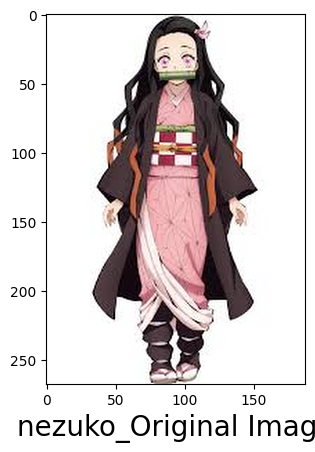

********* Predictions ***********


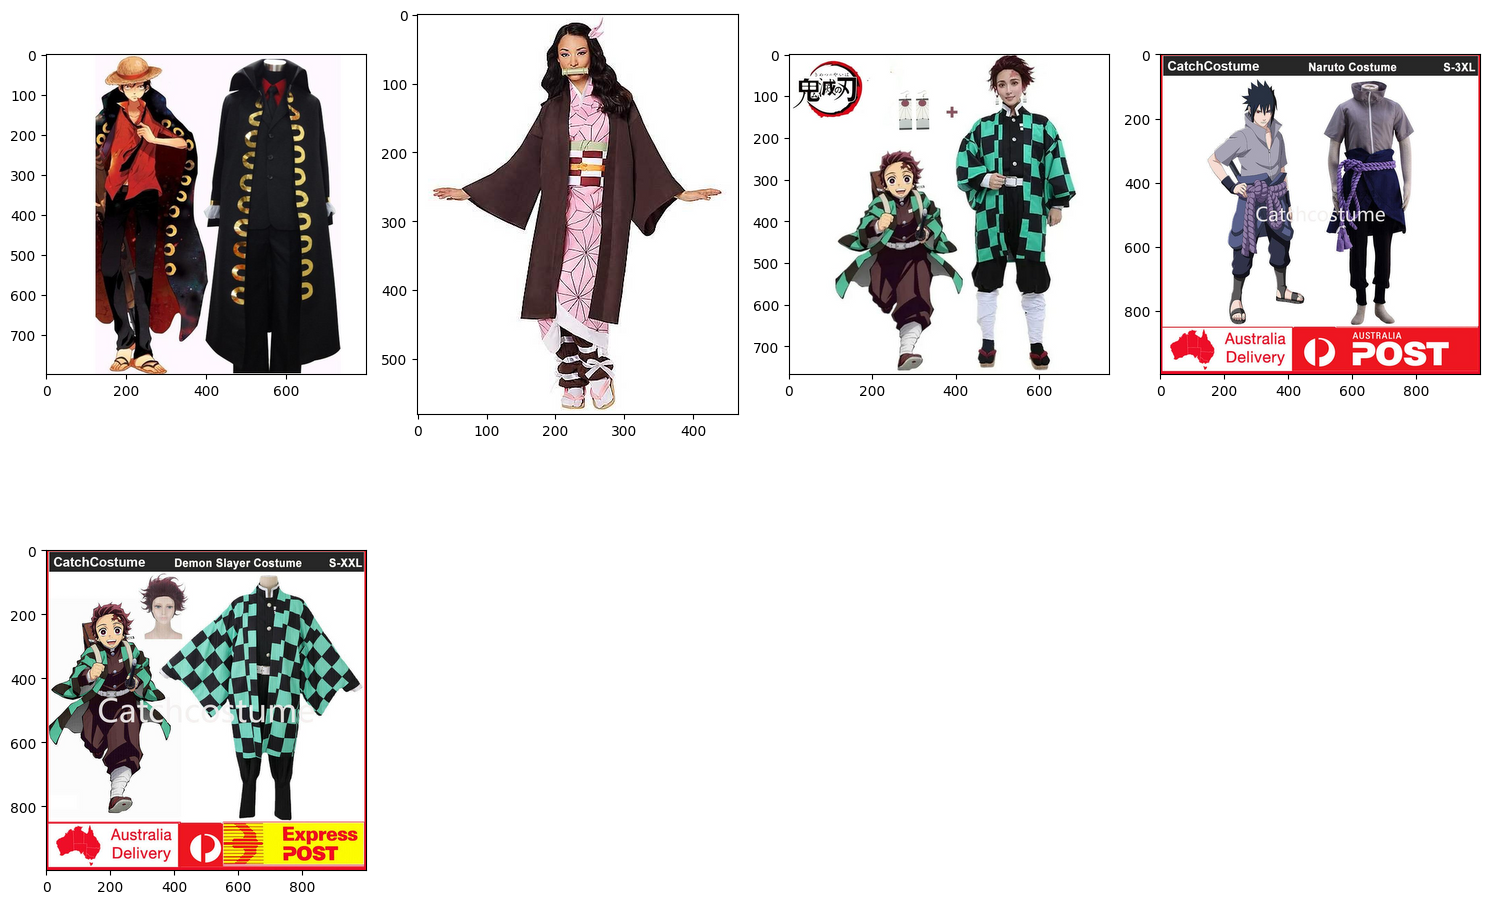

In [ ]:
test_img_compressed = pca.transform(test_img_features)
distances, indices = neighbors_pca_features.kneighbors(test_img_compressed)
print(indices.shape)
plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
import numpy as np

def evaluate_similarity_search(true_labels, retrieved_labels, k=5):

    precision_scores = []
    recall_scores = []
    accuracy_scores = []

    for i in range(len(true_labels)):
        true_label = true_labels[i]

        correct_retrievals = sum([1 for label in retrieved_labels[i] if label == true_label])

        precision = correct_retrievals / k
        recall = correct_retrievals / 1  # Each query has one true label
        accuracy = 1 if true_label in retrieved_labels[i] else 0

        precision_scores.append(precision)
        recall_scores.append(recall)
        accuracy_scores.append(accuracy)

    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_accuracy = np.mean(accuracy_scores)

    return avg_precision, avg_recall, avg_accuracy

true_labels = [filename.split('/')[-2] for filename in filenames]

_, original_indices = neighbors.kneighbors(feature_list)
original_retrieved_labels = [
    [true_labels[idx] for idx in original_indices[i]] for i in range(len(true_labels))
]

_, pca_indices = neighbors_pca_features.kneighbors(compressed_features)
pca_retrieved_labels = [
    [true_labels[idx] for idx in pca_indices[i]] for i in range(len(true_labels))
]

original_metrics = evaluate_similarity_search(true_labels, original_retrieved_labels, k=5)
pca_metrics = evaluate_similarity_search(true_labels, pca_retrieved_labels, k=5)




print("Original Features Metrics:")
print(f"Precision: {original_metrics[0]:.2f}, Recall: {original_metrics[1]:.2f}, Accuracy: {original_metrics[2]:.2f}")

print("\nPCA-Compressed Features Metrics:")
print(f"Precision: {pca_metrics[0]:.2f}, Recall: {pca_metrics[1]:.2f}, Accuracy: {pca_metrics[2]:.2f}")




NameError: name 'neighbors_pca_features' is not defined

Confusion Matrix for Original Features:


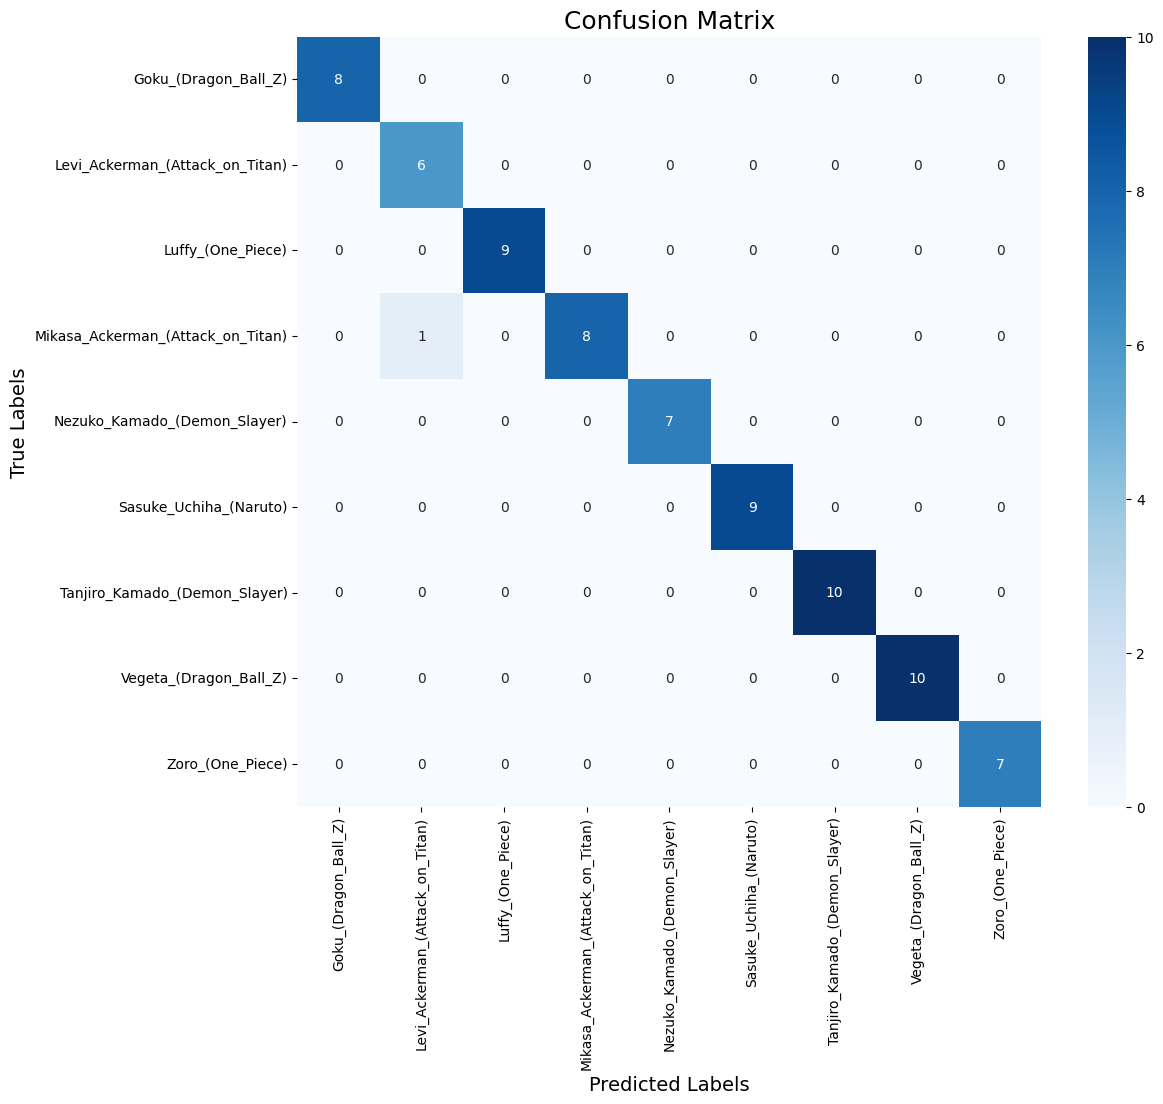


Confusion Matrix for PCA-Compressed Features:


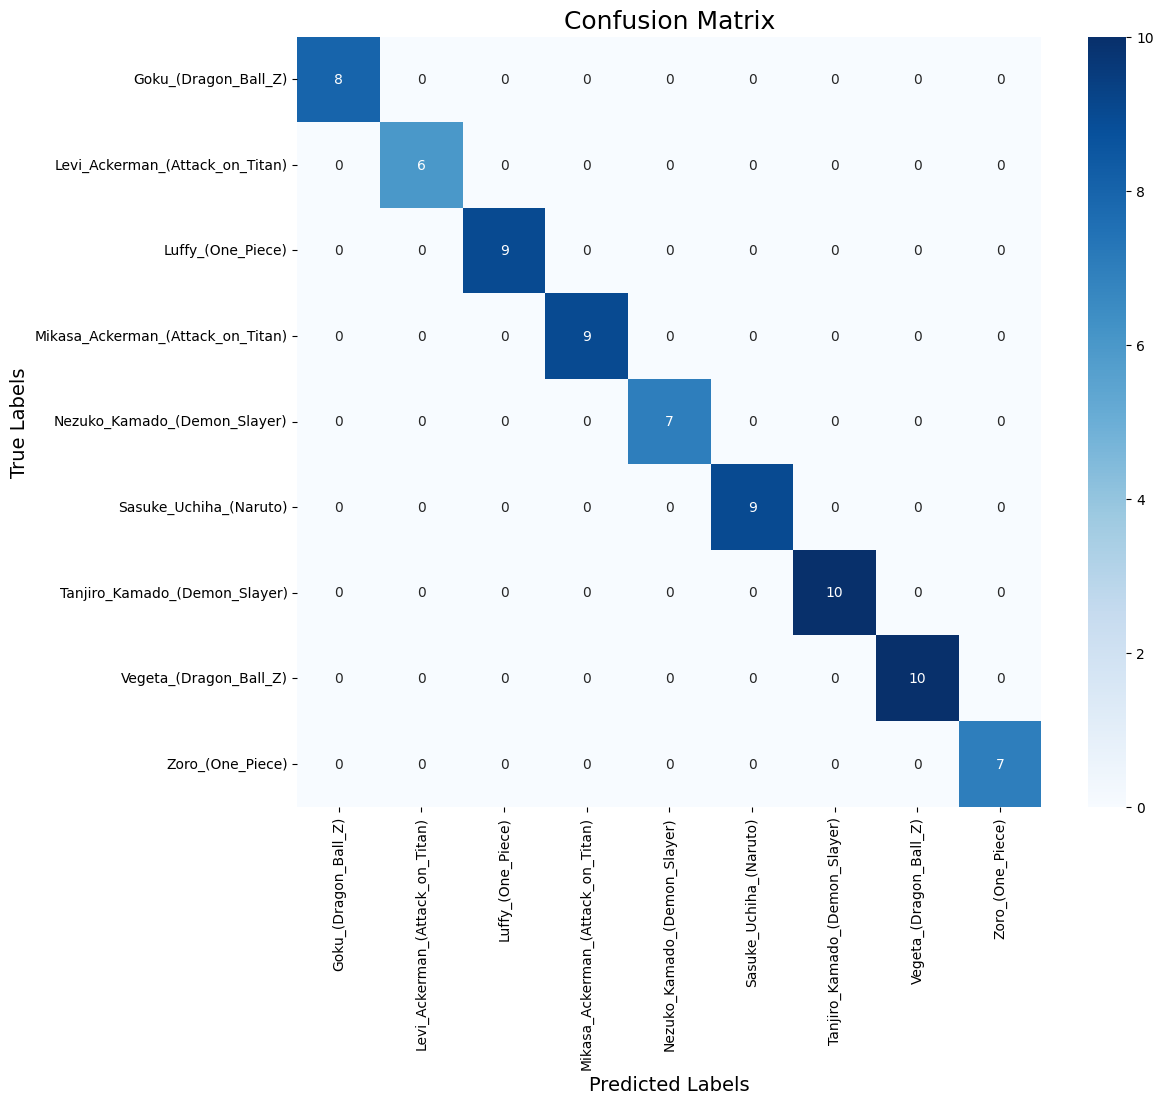

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_labels, retrieved_labels, class_names):
    """
    Plot the confusion matrix for similarity search.
    true_labels: List of ground truth labels for the input images.
    retrieved_labels: List of predicted labels for the most similar image.
    class_names: List of all class names.
    """
    # For simplicity, consider the label of the most similar image
    predicted_labels = [retrieved[0] for retrieved in retrieved_labels]

    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)

    # Plot the confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix", fontsize=18)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.show()

# Get unique class names
class_names = sorted(list(set(true_labels)))

# Plot confusion matrix for original features
print("Confusion Matrix for Original Features:")
plot_confusion_matrix(true_labels, original_retrieved_labels, class_names)

# Plot confusion matrix for PCA-compressed features
print("\nConfusion Matrix for PCA-Compressed Features:")
plot_confusion_matrix(true_labels, pca_retrieved_labels, class_names)


## Siamese and Triplets Network

https://medium.com/@hayagriva99999/exploring-siamese-networks-for-image-similarity-using-contrastive-loss-f5d5ae5a0cc6#:~:text=Siamese%20neural%20networks%20are%20a,the%20same%20set%20of%20weights.
https://elcaiseri.medium.com/image-similarity-estimation-using-a-siamese-network-with-triplet-loss-a-practical-guide-124938e24b3a


In [24]:
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image

def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

from glob import glob

In [29]:
anchor_images_path = []
positive_images_path = []

for class_ in os.listdir('/content/drive/MyDrive/Caltech101/101_ObjectCategories'):
    class_imgs_path = glob(f'/content/drive/MyDrive/Caltech101/101_ObjectCategories/{class_}/*.jpg')

    if (len(class_imgs_path) % 2):
        class_imgs_path = class_imgs_path[1:]

    n = len(class_imgs_path) // 2

    anchor_images_path.extend(class_imgs_path[:n]) # select some cats as anchors
    positive_images_path.extend(class_imgs_path[n:]) # select some cats as positive samples

    #break

In [30]:
print('Anchor samples size:', len(anchor_images_path), 'images')
print('Positive samples size:', len(positive_images_path), 'images')

Anchor samples size: 4310 images
Positive samples size: 4310 images


In [31]:
target_shape = (200,200);
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
anchor_images = sorted(anchor_images_path)

positive_images = sorted(positive_images_path)

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

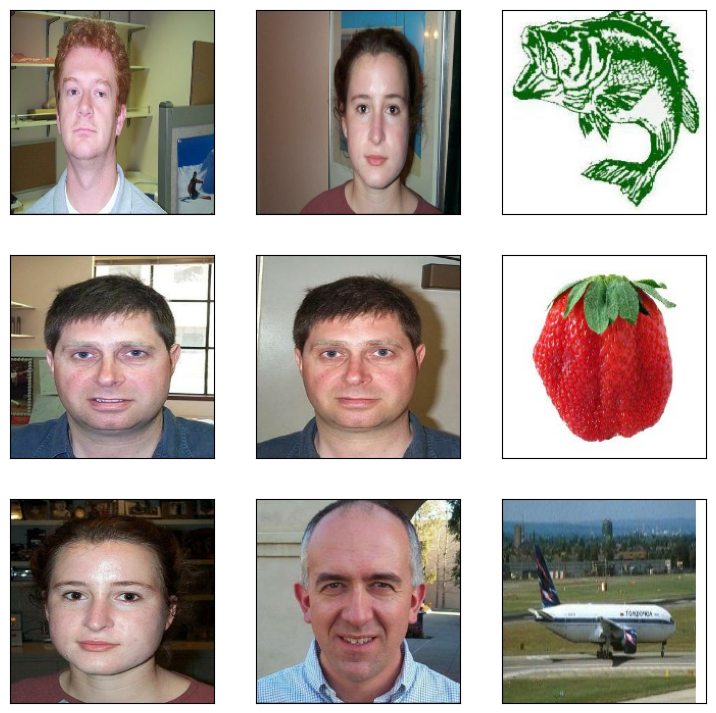

In [32]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        # print(anchor[i],positive[i],negative[i])
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [33]:
base_cnn = ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

# Freeze all layers until the layer conv5_block1_out
trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [35]:


class DistanceLayer(layers.Layer):
    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(respre(anchor_input)),
    embedding(respre(positive_input)),
    embedding(respre(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [36]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1112s 10s/step - loss: 0.4737 - val_loss: 0.3214
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - loss: 0.2149

tf.Tensor(
[[[0.06469608 0.13528432 0.14863725]
  [0.09089608 0.14783335 0.15349215]
  [0.09920589 0.14626472 0.14626472]
  ...
  [0.15686275 0.30588236 0.21568629]
  [0.17269878 0.31387475 0.22681615]
  [0.13210766 0.26151943 0.1791665 ]]

 [[0.08271569 0.14153922 0.15330392]
  [0.10546079 0.16036275 0.16193138]
  [0.11330393 0.16036275 0.15251961]
  ...
  [0.15686275 0.30588236 0.21568629]
  [0.1766402  0.3178162  0.23075756]
  [0.18966025 0.319072   0.23671907]]

 [[0.09882354 0.15372549 0.15764706]
  [0.1336961  0.17604902 0.17369609]
  [0.14308824 0.17838235 0.16661765]
  ...
  [0.15686275 0.30588236 0.21568629]
  [0.15843147 0.2996075  0.21254885]
  [0.18121597 0.31062773 0.2282748 ]]

 ...

 [[0.18065675 0.20939215 0.19416673]
  [0.28219596 0.28533322 0.24225482]
  [0.40372533 0.3782842  0.31171566]
  ...
  [0.07450981 0.14509805 0.15294118]
  [0.07450981 0.14509805 0.15294118]
  [0.07450981 0.14509805 0.15294118]]

 [[0.14347073 0.18352942 0.17986076]
  [0.2371669  0.25206885 0

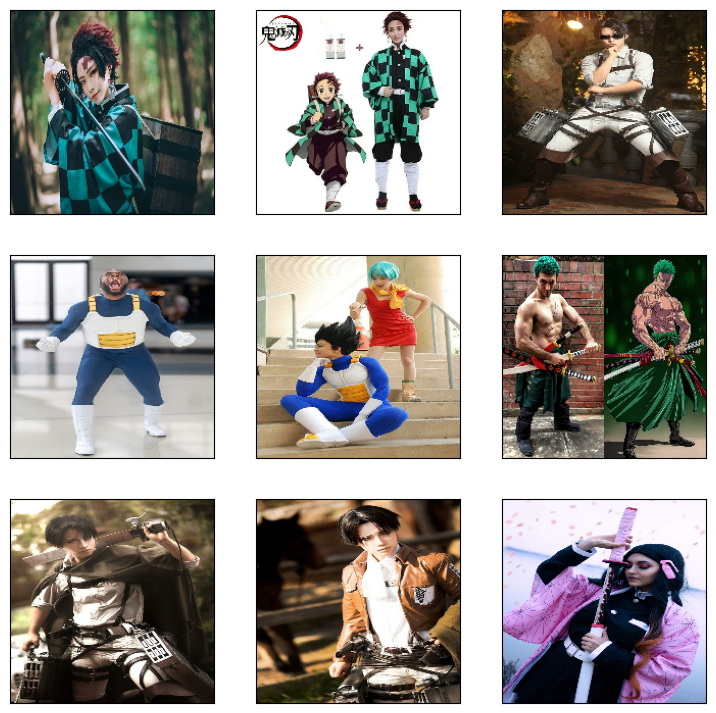

In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(respre(anchor)),
    embedding(respre(positive)),
    embedding(respre(negative)),
)

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity:", negative_similarity.numpy())

Positive similarity: 0.9963672
Negative similarity: 0.9941685


In [ ]:
# prompt: # Calculate embeddings for all images in your dataset feature_list calculate it for images in /content/drive/MyDrive/Caltech101/image_cos2 featurelist, filenames datagen, nothing are deifned

import tarfile
from PIL import Image, UnidentifiedImageError
from sklearn.metrics import confusion_matrix
import seaborn as sns

# ... (Your existing code) ...


# Calculate embeddings for all images in the dataset
feature_list = []
filenames = []
for filename in tqdm(datagen.filenames):
    try:
        img_path = os.path.join(root_dir, filename)
        img = image.load_img(img_path, target_size=(img_size, img_size))
        img_array = image.img_to_array(img)
        expanded_img_array = np.expand_dims(img_array, axis=0)
        preprocessed_img = preprocess_input(expanded_img_array)
        feature = model.predict(preprocessed_img, batch_size=1)
        feature_list.append(feature.flatten())  # Flatten the feature vector
        filenames.append(img_path)
    except Exception as e:
        print(f"Error processing {filename}: {e}")

feature_list = np.array(feature_list)
print("Shape of feature_list:", feature_list.shape)

# ... (Rest of your code) ...

100%|██████████| 75/75 [00:00<00:00, 1515.74it/s]

Error processing Goku_(Dragon_Ball_Z)/image_1.jpeg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Caltech101/101_ObjectCategories/Goku_(Dragon_Ball_Z)/image_1.jpeg'
Error processing Goku_(Dragon_Ball_Z)/image_10.jpeg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Caltech101/101_ObjectCategories/Goku_(Dragon_Ball_Z)/image_10.jpeg'
Error processing Goku_(Dragon_Ball_Z)/image_2.jpeg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Caltech101/101_ObjectCategories/Goku_(Dragon_Ball_Z)/image_2.jpeg'
Error processing Goku_(Dragon_Ball_Z)/image_3.jpeg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Caltech101/101_ObjectCategories/Goku_(Dragon_Ball_Z)/image_3.jpeg'
Error processing Goku_(Dragon_Ball_Z)/image_4.jpeg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Caltech101/101_ObjectCategories/Goku_(Dragon_Ball_Z)/image_4.jpeg'
Error processing Goku_(Dragon_Ball_Z)/image_5.jpeg: [Errno 2] No such file or directory: '/content

In [ ]:
# Predict embedding for test image
def predict_embedding(img_path):
    img = image.load_img(img_path, target_size=(target_shape[0], target_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    return embedding.predict(preprocessed_img, batch_size=1)

# Example usage: Upload and predict
from google.colab import files
uploaded = files.upload()
img_path = list(uploaded.keys())[0]  # Get the name of the uploaded file
test_img_features = predict_embedding(img_path)

# Ensure test_img_features has correct shape
print("Test image features shape:", test_img_features.shape)
test_img_features = np.squeeze(test_img_features, axis=0)
print("Test image features shape:", test_img_features.shape)


# Ensure feature_list has correct shape
if 'feature_list' not in locals():
    feature_list = embedding.predict(datagen, steps=len(datagen))
print("Feature list shape:", feature_list.shape)

# Fit NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', metric='euclidean')
neighbors.fit(feature_list)

# Find similar images
distances, indices = neighbors.kneighbors([test_img_features])  # Add batch dimension
print("Indices of similar images:", indices)

# Display similar images
def similar_images(indices):
    plt.figure(figsize=(15, 10), facecolor='white')
    plotnumber = 1
    for index in indices[0]:  # Unpack first dimension
        if plotnumber <= len(indices[0]):
            ax = plt.subplot(2, 4, plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')
            plotnumber += 1
    plt.tight_layout()

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image', fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices)


## Vision Transformer
https://pub.towardsai.net/vision-embedding-comparison-for-image-similarity-search-efficientnet-vs-4eac6bf553c4
https://medium.com/@tapanbabbar/build-an-image-similarity-search-with-transformers-vit-clip-efficientnet-dino-v2-and-blip-2-5040d1848c00
https://medium.com/red-buffer/diving-into-clip-by-creating-semantic-image-search-engines-834c8149de56


In [18]:
!pip install transformers timm torch torchvision


In [23]:
from transformers import ViTFeatureExtractor, ViTModel
import torch
from PIL import Image



feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)

def generate_vit_embedding(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = feature_extractor(images=image, return_tensors="pt").to(device)  # Send to GPU

        with torch.no_grad():
            outputs = vit_model(**inputs)

        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0)  # (1, 768) -> (768)
        return cls_embedding.cpu().numpy()  # Move back to CPU for NumPy compatibility
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None



def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify the file is a valid image
        return True
    except (IOError, SyntaxError, UnidentifiedImageError):
        return False



root_dir = '/content/drive/MyDrive/Caltech101/101_ObjectCategories'

image_paths = []
embeddings = []

for dirpath, _, filenames in os.walk(root_dir):
    for file in filenames:
        file_path = os.path.join(dirpath, file)
        if is_valid_image(file_path):
            image_paths.append(file_path)
            # embedding = generate_vit_embedding(file_path)
            # if embedding is not None:
                # embeddings.append(embedding)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
root_dir = '/content/drive/MyDrive/Caltech101/101_ObjectCategories'

image_paths = []
embeddings = []

for dirpath, _, filenames in os.walk(root_dir):
    for file in filenames:
        file_path = os.path.join(dirpath, file)
        if is_valid_image(file_path):
            image_paths.append(file_path)

In [ ]:
feature_list = np.array(embeddings)
print("Num images:", len(image_paths))
print("Shape of feature_list:", feature_list.shape)

Num images: 8677
Shape of feature_list: (8677, 768)


In [ ]:
from google.colab import files
np.save('feature_list.npy', feature_list)  # Save feature_list as a .npy file
files.download('feature_list.npy')  # Download the file to your local system

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Reduce dimensionality with PCA (optional)
pca = PCA(n_components=128, random_state=42)  # Adjust components as needed
reduced_embeddings = pca.fit_transform(embeddings)

In [ ]:
!pip install datasketch
from datasketch import MinHashLSH, MinHash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 4.5 MB/s eta 0:00:00


In [ ]:
# Create LSH index
print("Building LSH index...")
lsh = MinHashLSH(threshold=0.2, num_perm=128)

# Insert images into LSH buckets
for i, embedding in enumerate(reduced_embeddings):
    minhash = MinHash(num_perm=128)
    for value in embedding:
        minhash.update(value.tobytes())
    lsh.insert(f"image_{i}", minhash)


Building LSH index...


In [ ]:
# Query for similar images
def query_similar_images(query_image_path, top_n=5):
    query_embedding = generate_vit_embedding(query_image_path)
    if query_embedding is None:
        print("Error generating embedding for the query image.")
        return

    # Reduce dimensionality of the query embedding
    query_reduced = pca.transform(query_embedding.reshape(1, -1))

    # Create MinHash for the query image
    query_minhash = MinHash(num_perm=128)
    for value in query_reduced[0]:
        query_minhash.update(value.tobytes())

    # Retrieve similar items from LSH
    result_keys = list(lsh.query(query_minhash))
    if not result_keys:
        print("No similar images found.")
        return

    # Retrieve corresponding image paths
    similar_images = [image_paths[int(key.split("_")[1])] for key in result_keys[:top_n]]
    return similar_images

from google.colab import files
uploaded = files.upload()


Saving cat.jpg to cat (2).jpg


In [ ]:

# Example usage
query_image_path = 'cat.jpg'
print("Finding similar images...")
similar_images = query_similar_images(query_image_path)

# Display query and similar images
if similar_images:
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    plt.figure(figsize=(15, 10))
    plt.subplot(2, 4, 1)
    plt.imshow(mpimg.imread(query_image_path))
    plt.title("Query Image")
    plt.axis('off')

    for i, img_path in enumerate(similar_images):
        plt.subplot(2, 4, i + 2)
        plt.imshow(mpimg.imread(img_path))
        plt.title(f"Similar {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Finding similar images...
No similar images found.


In [19]:

# Load the .npy file into a NumPy array
npy_file_path = "/content/drive/MyDrive/Caltech101/feature_list.npy"

try:
    feature_list = np.load(npy_file_path)
    print("Loaded feature list successfully!")
    print("Shape of the feature list:", feature_list.shape)
except Exception as e:
    print(f"Error loading .npy file: {e}")

Loaded feature list successfully!
Shape of the feature list: (8677, 768)


In [20]:
neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', metric='euclidean')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='ball_tree', metric='euclidean')

In [21]:
from google.colab import files
uploaded = files.upload()

Saving cat.jpg to cat.jpg


Indices of similar images: [[5725 5726 5721 5723 5733]]


FileNotFoundError: [Errno 2] No such file or directory: '/content/joshua_tree/image_0001.jpg'

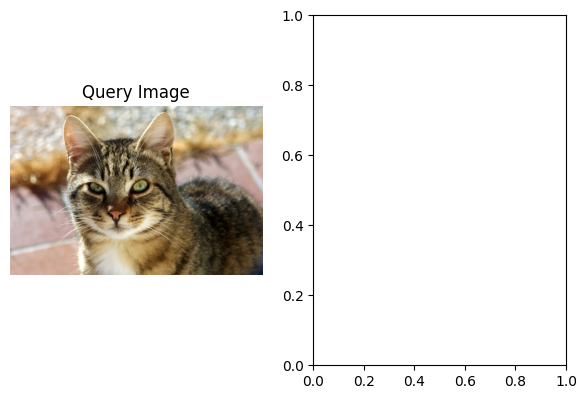

In [25]:
# Predict similar images for a given query image
query_image_path = 'cat.jpg'
query_embedding = generate_vit_embedding(query_image_path)
if query_embedding is not None:
    distances, indices = neighbors.kneighbors([query_embedding])  # Add batch dimension
    print("Indices of similar images:", indices)

    # Display similar images
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    def display_similar_images(indices, query_image_path):
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 4, 1)
        plt.imshow(mpimg.imread(query_image_path))
        plt.title("Query Image")
        plt.axis('off')

        for i, idx in enumerate(indices[0]):
            plt.subplot(2, 4, i + 2)
            plt.imshow(mpimg.imread(datagen.filenames[idx]))
            plt.title(f"Similar {i+1}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    display_similar_images(indices, query_image_path)


In [ ]:
import os
import math
import numpy as np
from tqdm import tqdm
from PIL import Image, UnidentifiedImageError
from sklearn.neighbors import NearestNeighbors
from transformers import ViTFeatureExtractor, ViTModel
import torch

# Load pre-trained ViT model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224")

# Function to validate image files and catch UnidentifiedImageError
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify the file is a valid image
        return True
    except (IOError, SyntaxError, UnidentifiedImageError):
        return False

# Generate ViT embeddings for a given image
def generate_vit_embedding(image_path):
    try:
        # Load and preprocess image
        image = Image.open(image_path).convert("RGB")
        inputs = feature_extractor(images=image, return_tensors="pt")

        # Extract embeddings
        with torch.no_grad():
            outputs = vit_model(**inputs)

        # Use the [CLS] token's embedding for the image
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0)  # (1, 768) -> (768)
        return cls_embedding.numpy()
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Parameters
root_dir = '/content/drive/MyDrive/Caltech101/101_ObjectCategories'

# Validate all images and generate embeddings
print("Validating and processing images...")
image_paths = []
embeddings = []

for dirpath, _, filenames in os.walk(root_dir):
    for file in filenames:
        file_path = os.path.join(dirpath, file)
        if is_valid_image(file_path):
            image_paths.append(file_path)
            embedding = generate_vit_embedding(file_path)
            if embedding is not None:
                embeddings.append(embedding)

# Convert embeddings to numpy array
feature_list = np.array(embeddings)
print("Num images:", len(image_paths))
print("Shape of feature_list:", feature_list.shape)

# Fit the NearestNeighbors model
neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', metric='euclidean')
neighbors.fit(feature_list)

# Predict similar images for a given query image
query_image_path = 'nezuko.jpeg'
query_embedding = generate_vit_embedding(query_image_path)
if query_embedding is not None:
    distances, indices = neighbors.kneighbors([query_embedding])  # Add batch dimension
    print("Indices of similar images:", indices)

    # Display similar images
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    def display_similar_images(indices, query_image_path):
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 4, 1)
        plt.imshow(mpimg.imread(query_image_path))
        plt.title("Query Image")
        plt.axis('off')

        for i, idx in enumerate(indices[0]):
            plt.subplot(2, 4, i + 2)
            plt.imshow(mpimg.imread(image_paths[idx]))
            plt.title(f"Similar {i+1}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    display_similar_images(indices, query_image_path)


# Other approaches for CBIR



